In [1]:
from utils import *
import tensorflow as tf
tf_fix(tf)
import tensorflow.keras.backend as K
# K.set_floatx('float16')
# K.set_epsilon(1e-4)
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import rxrx.io

In [2]:
images = {}
for split in ['train', 'val', 'test']:
    images[split] = np.load(os.path.join(RECURSION_DIR, 'npy', 'controls', split, f'controls-{split}-f32.npy'))

In [3]:
images = np.concatenate(list(images.values()))

In [4]:
labels = np.zeros((images.shape[0:4]), dtype=np.float32)

In [5]:
for i in range(len(labels)):
    labels[i] = i

In [6]:
images_reshaped = images.reshape((np.product(images.shape[0:4]), *images.shape[4:]))
labels = labels.reshape((np.product(images.shape[0:4])))

In [7]:
class L0Loss:
    def __init__(self):
        self.gamma = K.variable(2.)

    def __call__(self):
        def calc_loss(y_true, y_pred):
            loss = K.pow(K.abs(y_true - y_pred) + 1e-8, self.gamma)
            return loss
        return calc_loss

In [8]:
def _conv_block(x, num_filters, act, bn, res, dropout_rate=0):
    z = Conv2D(filters=num_filters, kernel_size=3, activation=act, padding='same')(x)
    z = BatchNormalization()(z) if bn else z
    z = Dropout(rate=dropout_rate)(z) if dropout_rate else z
    z = Conv2D(filters=num_filters, kernel_size=3, activation=act, padding='same')(z)
    z = BatchNormalization()(z) if bn else z
    z = Concatenate()([z, x]) if res else z
    return z

In [9]:
def _level_block(x, depth, increment_rate, upsampling, max_pooling,
                 num_filters, act, bn, res, dropout_rate):
    if depth > 0:
        z = _conv_block(x, num_filters, act, bn, res)
        j = MaxPooling2D()(z) if max_pooling else Conv2D(num_filters, 3, strides=2, padding='same')(z)
        j = _level_block(j, depth-1, increment_rate, upsampling, max_pooling,
                        int(num_filters * increment_rate), act, bn, res, dropout_rate)
        
        if upsampling:
            j = UpSampling2D()(j)
            j = Conv2D(num_filters, kernel_size=2, activation=act, padding='same')(j)
        else:
            j = Conv2DTranspose(num_filters, kernel_size=3, strides=2, activation=act, padding='same')(j)
        z = Concatenate()([z, j])
        z = _conv_block(z, num_filters, act, bn, res)
        
    else:
        z = _conv_block(x, num_filters, act, bn, res, dropout_rate)
        
    return z  

In [10]:
def build_noise2noise(input_shape, input_channels, output_channels,
                      depth=4, increment_rate=2, upsampling=True, max_pooling=True,
                      num_filters=64, act='relu', bn=False, res=False, dropout_rate=.4):
    i = Input(shape=(*input_shape, input_channels))
    z = _level_block(i, depth, increment_rate, True, True, num_filters, act, bn, res, dropout_rate)
    z = Conv2D(output_channels, 1)(z)
    model = Model(inputs=i, outputs=z, name='noise2noise')
    return model

In [11]:
model = build_noise2noise((512, 512), 6, 6)

In [12]:
model.compile(optimizer='adam', loss=L0Loss()())

In [13]:
model.fit(x=images_reshaped, y=images_reshaped, batch_size=4)

Train on 1624 samples
1624/1624 [==============================] - 321s 197ms/sample - loss: 5.8535e-04


In [14]:
i = 10

In [ ]:
model.predict(x[None, :])

In [16]:
x = images_reshaped[i]
x_hat = model(x[None, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x)
axes[1].imshow(x_hat)

InternalError: Blas SGEMM launch failed : m=262144, n=6, k=64 [Op:Conv2D]

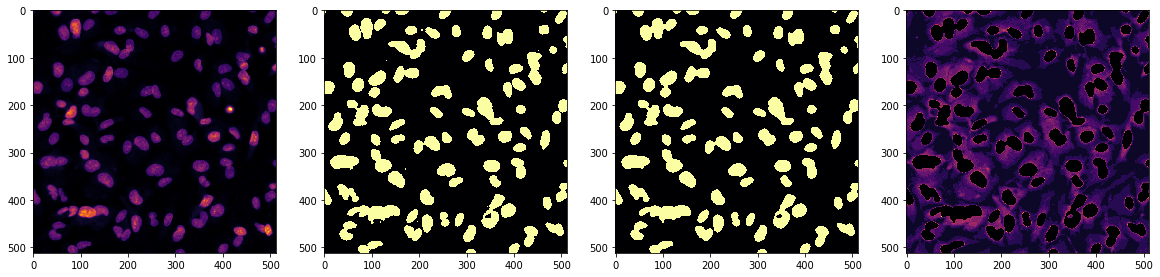

In [113]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
x = images[1, 1, 0, 0, :, :, 0].copy()
axes[0].imshow(x , 'inferno')
threshold = x.mean()
simple_mask = x>threshold
axes[1].imshow(simple_mask , 'inferno')
median_mask = cv2.medianBlur(x, 7)>threshold
axes[2].imshow(median_mask, 'inferno')
x[np.where(median_mask)]=0
axes[3].imshow(x, 'inferno')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x = images[0, 0, 0, 0, :, :, 0]
axes[0].imshow(x , 'inferno')
axes[1].imshow(x>.1 , 'inferno')
axes[2].imshow(cv2.medianBlur(x, 7)>.1, 'inferno')